In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
#import Image
import sys
import os
from  math import pow
from PIL import Image, ImageDraw, ImageFont
import cv2
import math
import random
caffe_root = '/home/ren/caffe/' #caffe的路径
face_detect = '/home/ren/eclipse-workspace/face_detect'

sys.path.insert(0, caffe_root + 'python')
#sys.path.insert(1, "./crnn")定义搜索路径的优先顺序，序号从0开始，表示最大优先级，
#sys.path.insert()加入的也是临时搜索路径，程序退出后失效。

os.environ['GLOG_minloglevel'] = '2'
import caffe
# caffe.set_device(0)
# caffe.set_mode_gpu()


# 这一部分主要用来构建NMS极大值抑制函数

In [2]:
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
def calculateDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def range_overlap(a_min, a_max, b_min, b_max):

    return (a_min <= b_max) and (b_min <= a_max)

def rect_overlaps(r1,r2):
    return range_overlap(r1.left, r1.right, r2.left, r2.right) and range_overlap(r1.bottom, r1.top, r2.bottom, r2.top)

def rect_merge(r1,r2, mergeThresh):

    if rect_overlaps(r1,r2):
        # dist = calculateDistance((r1.left + r1.right)/2, (r1.top + r1.bottom)/2, (r2.left + r2.right)/2, (r2.top + r2.bottom)/2)
        SI= abs(min(r1.right, r2.right) - max(r1.left, r2.left)) * abs(max(r1.bottom, r2.bottom) - min(r1.top, r2.top))
        SA = abs(r1.right - r1.left)*abs(r1.bottom - r1.top)
        SB = abs(r2.right - r2.left)*abs(r2.bottom - r2.top)
        S=SA+SB-SI
        ratio = float(SI) / float(S)
        if ratio > mergeThresh :
            return 1
    return 0
class Rect(object):
    def __init__(self, p1, p2):
        '''Store the top, bottom, left and right values for points
               p1 and p2 are the (corners) in either order
        '''
        self.left   = min(p1.x, p2.x)
        self.right  = max(p1.x, p2.x)
        self.bottom = min(p1.y, p2.y)
        self.top    = max(p1.y, p2.y)

    def __str__(self):
        return "Rect[%d, %d, %d, %d]" % ( self.left, self.top, self.right, self.bottom )
def nms_average(boxes, groupThresh=2, overlapThresh=0.2):
    #groupThresh:默认当框的个数大于该参数时，进行合并，否则不进行合并
    #overlapThresh：剔除重合比例大于该参数的框
    rects = []
    for i in range(len(boxes)):
        if boxes[i][4] > 0.2:
            rects.append([boxes[i,0], boxes[i,1], boxes[i,2]-boxes[i,0], boxes[i,3]-boxes[i,1]])


    rects, weights = cv2.groupRectangles(rects, groupThresh, overlapThresh)

    rectangles = []
    for i in range(len(rects)):

        testRect = Rect( Point(rects[i,0], rects[i,1]), Point(rects[i,0]+rects[i,2], rects[i,1]+rects[i,3]))
        rectangles.append(testRect)
    clusters = []
    for rect in rectangles:
        matched = 0
        for cluster in clusters:
            if (rect_merge( rect, cluster , 0.2) ):
                matched=1
                cluster.left   =  (cluster.left + rect.left   )/2
                cluster.right  = ( cluster.right+  rect.right  )/2
                cluster.top    = ( cluster.top+    rect.top    )/2
                cluster.bottom = ( cluster.bottom+ rect.bottom )/2

        if ( not matched ):
            clusters.append( rect )
    result_boxes = []
    for i in range(len(clusters)):

        result_boxes.append([clusters[i].left, clusters[i].bottom, clusters[i].right, clusters[i].top, 1])

    return result_boxes


In [3]:
#生成人脸框：如果发现存在人脸，要从featureMap的坐标映射到原图中的坐标
#featureMap是经过变换之后的图像经过全卷积的Alenet网络最后得到的一个特征图，该特征图上每一个点的数值代表对应原图是人脸的概率
def generateBoundingBox(featureMap, scale):
    boundingBox = []
    stride = 32 #在alenet网络中所有的stride步长相乘得到的
    cellSize = 227
    
    #进行反向变换：从featureMap的坐标映射到原图中的坐标
    for (x,y), prob in np.ndenumerate(featureMap):
        if(prob >= 0.95):
            #在原图象中人脸框的坐标：[左上角坐标，右下角坐标]=[左上y，左上x，右下y，右下x]
            boundingBox.append([float(stride * y)/ scale, 
                                float(x * stride)/scale, 
                                float(stride * y + cellSize - 1)/scale, 
                                float(stride * x + cellSize - 1)/scale, prob])

    return boundingBox

In [4]:
def face_detection(imgFile):
    
    #定义测试模型：
    #参数：测试模型的配置文件，训练后的模型，默认的参数
    net_full_conv = caffe.Net(os.path.join(face_detect, 'deploy_full_conv.prototxt'),
                              os.path.join(face_detect, 'model', 'alexnet_iter_50000_full_conv.caffemodel'),
                              caffe.TEST)
    
    #进行多尺度变换，构建图像金字塔
    scales = [] #存放图片变换的比例
    factor = 0.3 #变换比例
    img = cv2.imread(imgFile) #读取图像 
    largest = min(2, 4000/max(img.shape[0:2])) #最大将原图像放大两倍，放大后的图像最大长宽为4000
    scale = largest
    minD = largest*min(img.shape[0:2])
    while minD >= 227:
        scales.append(scale)
        scale *= factor
        minD *= factor

    #用来存人脸框
    total_boxes = []

    for scale in scales:
        #对图片进行resize操作
        scale_img = cv2.resize(img,((int(img.shape[0] * scale), int(img.shape[1] * scale))))
        cv2.imwrite('/home/ren/eclipse-workspace/face_detect/scale_image/scale_img.jpg',scale_img)
        #读入变换后的图片
        im = caffe.io.load_image('/home/ren/eclipse-workspace/face_detect/scale_image/scale_img.jpg')
        
        #对数据进行预处理
        net_full_conv.blobs['data'].reshape(1,3,scale_img.shape[1],scale_img.shape[0])
        transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
        #去均值化处理
        transformer.set_mean('data', np.load(caffe_root +
                                             'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
        transformer.set_transpose('data', (2,0,1))
        transformer.set_channel_swap('data', (2,1,0)) #对RGB图像模式进行变换
        transformer.set_raw_scale('data', 255.0) #是否对图片像素值的大小进行归一化，要与训练集保持统一即可
        
        #执行transformer操作，并进行前向传播
        out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
        #将所有的boxes添加到total_boxes
        boxes = generateBoundingBox(out['prob'][0,1], scale)
        if(boxes):
            total_boxes.extend(boxes)
    
    #NMS极大值抑制：对这些高度重合的人脸框进行剔除筛选
    boxes_nms = np.array(total_boxes)
    true_boxes = nms_average(boxes_nms, 1, 0.2)
    if not true_boxes == []:
        (x1, y1, x2, y2) = true_boxes[0][:-1]#取坐标
        #print (x1, y1, x2, y2)
        #绘制该长方形
        cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),thickness = 5)
        cv2.imwrite('/home/ren/eclipse-workspace/face_detect/result.jpg',img)

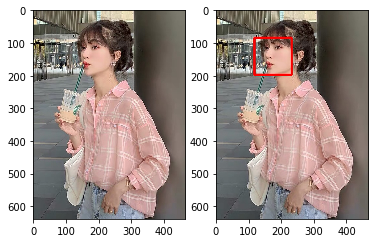

In [5]:
imgFile = '/home/ren/eclipse-workspace/face_detect/IMG_0026.JPG'
img = plt.imread(imgFile)
plt.subplot(121)
plt.imshow(img)

face_detection(imgFile)
img = plt.imread('/home/ren/eclipse-workspace/face_detect/result.jpg')
plt.subplot(122)
plt.imshow(img)
plt.show()

#  进行debug

In [6]:
#定义测试模型：
#参数：测试模型的配置文件，训练后的模型，默认的参数
net_full_conv = caffe.Net(os.path.join(face_detect, 'deploy_full_conv.prototxt'),
                          os.path.join(face_detect, 'model', 'alexnet_iter_50000_full_conv.caffemodel'),
                          caffe.TEST)

#进行多尺度变换，构建图像金字塔
scales = [] #存放图片变换的比例
factor = 0.3 #变换比例
imgFile = '/home/ren/eclipse-workspace/face_detect/IMG_0026.JPG'
img = plt.imread(imgFile) #读取图像 
largest = min(2, 4000/max(img.shape[0:2])) #最大将原图像放大两倍，放大后的图像最大长宽为4000
scale = largest
minD = largest*min(img.shape[0:2])
while minD >= 227:
    scales.append(scale)
    scale *= factor
    minD *= factor

#用来存人脸框
total_boxes = []
# print(scales)
for scale in [scales[0]]:
    #对图片进行resize操作
    scale_img = cv2.resize(img,((int(img.shape[0] * scale), int(img.shape[1] * scale))))
    cv2.imwrite('/home/ren/eclipse-workspace/face_detect/scale_image/scale_img.jpg',scale_img)
    #读入变换后的图片
    im = caffe.io.load_image('/home/ren/eclipse-workspace/face_detect/scale_image/scale_img.jpg')

    #对数据进行预处理
    net_full_conv.blobs['data'].reshape(1,3,scale_img.shape[1],scale_img.shape[0])
    transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape}) 
    transformer.set_mean('data', np.load(caffe_root +'python/caffe/imagenet/ilsvrc_2012_mean.npy')
                         .mean(1).mean(1))#去均值化处理
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0)) #对RGB图像模式进行变换
    transformer.set_raw_scale('data', 255.0) #是否对图片像素值的大小进行归一化，要与训练集保持统一即可

    #执行transformer操作，并进行前向传播
    out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
    #将所有的boxes添加到total_boxes
    boxes = generateBoundingBox(out['prob'][0,1], scale)
    if(boxes):
        total_boxes.extend(boxes)

#NMS极大值抑制：对这些高度重合的人脸框进行剔除筛选
# print(total_boxes)

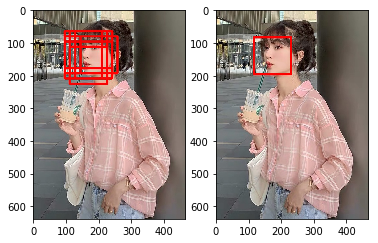

In [7]:
imgFile = '/home/ren/eclipse-workspace/face_detect/IMG_0026.JPG'
img = cv2.imread(imgFile) #读取图像 
boxes_nms = np.array(total_boxes)

for box in boxes_nms:
    (x1, y1, x2, y2) = box[:-1]#取坐标
    #绘制该长方形
    cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),thickness = 5)
    cv2.imwrite('/home/ren/eclipse-workspace/face_detect/result.jpg',img)
imgFile = '/home/ren/eclipse-workspace/face_detect/result.jpg'
img = plt.imread(imgFile)
plt.subplot(121)
plt.imshow(img)


#NMS极大值抑制：对这些高度重合的人脸框进行剔除筛选
imgFile = '/home/ren/eclipse-workspace/face_detect/IMG_0026.JPG'
img = cv2.imread(imgFile) #读取图像 
true_boxes = nms_average(boxes_nms, 1, 0.2)
#print(true_boxes)
if not true_boxes == []:
    (x1, y1, x2, y2) = true_boxes[0][:-1]#取坐标
    #print (x1, y1, x2, y2)
    #绘制该长方形
    cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),thickness = 5)
    cv2.imwrite('/home/ren/eclipse-workspace/face_detect/result.jpg',img)

imgFile = '/home/ren/eclipse-workspace/face_detect/result.jpg'
img = plt.imread(imgFile)
plt.subplot(122)
plt.imshow(img)
plt.show()

In [8]:
#定义测试模型：
#参数：测试模型的配置文件，训练后的模型，默认的参数
net_full_conv = caffe.Net(os.path.join(face_detect, 'deploy_full_conv.prototxt'),
                          os.path.join(face_detect, 'model', 'alexnet_iter_50000_full_conv.caffemodel'),
                          caffe.TEST)

#进行多尺度变换，构建图像金字塔
scales = [] #存放图片变换的比例
factor = 0.7 #变换比例
imgFile = '/home/ren/eclipse-workspace/face_detect/timg.jpg'
img = plt.imread(imgFile) #读取图像 
largest = min(2, 4000/max(img.shape[0:2])) #最大将原图像放大两倍，放大后的图像最大长宽为4000
scale = largest
minD = largest*min(img.shape[0:2])
while minD >= 227:
    scales.append(scale)
    scale *= factor
    minD *= factor

#用来存人脸框
total_boxes = []
print(scales)
for scale in scales:
    #对图片进行resize操作
    scale_img = cv2.resize(img,((int(img.shape[0] * scale), int(img.shape[1] * scale))))
    cv2.imwrite('/home/ren/eclipse-workspace/face_detect/scale_image/scale_img.jpg',scale_img)
    #读入变换后的图片
    im = caffe.io.load_image('/home/ren/eclipse-workspace/face_detect/scale_image/scale_img.jpg')

    #对数据进行预处理
    net_full_conv.blobs['data'].reshape(1,3,scale_img.shape[1],scale_img.shape[0])
    transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape}) 
    transformer.set_mean('data', np.load(caffe_root +'python/caffe/imagenet/ilsvrc_2012_mean.npy')
                         .mean(1).mean(1))#去均值化处理
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0)) #对RGB图像模式进行变换
    transformer.set_raw_scale('data', 255.0) #是否对图片像素值的大小进行归一化，要与训练集保持统一即可

    #执行transformer操作，并进行前向传播
    out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
    #将所有的boxes添加到total_boxes
    boxes = generateBoundingBox(out['prob'][0,1], scale)
    if(boxes):
        total_boxes.extend(boxes)

#NMS极大值抑制：对这些高度重合的人脸框进行剔除筛选
# print(total_boxes)

[2, 1.4, 0.9799999999999999, 0.6859999999999998]


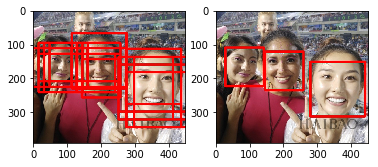

In [9]:
imgFile = '/home/ren/eclipse-workspace/face_detect/timg.jpg'
img = cv2.imread(imgFile) #读取图像 
boxes_nms = np.array(total_boxes)

for box in boxes_nms:
    (x1, y1, x2, y2) = box[:-1]#取坐标
    #绘制该长方形
    cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),thickness = 5)
    cv2.imwrite('/home/ren/eclipse-workspace/face_detect/result.jpg',img)
imgFile = '/home/ren/eclipse-workspace/face_detect/result.jpg'
img = plt.imread(imgFile)
plt.subplot(121)
plt.imshow(img)

#NMS极大值抑制：对这些高度重合的人脸框进行剔除筛选
imgFile = '/home/ren/eclipse-workspace/face_detect/timg.jpg'
img = cv2.imread(imgFile) #读取图像 
true_boxes = nms_average(boxes_nms, 2, 0.2)

for box in true_boxes:
    (x1, y1, x2, y2) = box[:-1]#取坐标
    #print (x1, y1, x2, y2)
    #绘制该长方形
    cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),thickness = 5)
    cv2.imwrite('/home/ren/eclipse-workspace/face_detect/result.jpg',img)

imgFile = '/home/ren/eclipse-workspace/face_detect/result.jpg'
img = plt.imread(imgFile)
plt.subplot(122)
plt.imshow(img)
plt.show()